# Production optimisation with ensembles – an interactive tutorial

Copyright Patrick N. Raanes, NORCE, 2023.

This is a tutorial on production optimisation using ensemble methods.
Please also have a look at the [history matching (HM) tutorial](HistoryMatch.ipynb)
for an introduction to Python, Jupyter notebooks, and this reservoir simulator.

#### Install
If you're on **Google Colab**, run the cell below to install the requirements.
Otherwise (and assuming you have done the installation described in the README),
you can skip/delete this cell.

In [4]:
remote = "https://raw.githubusercontent.com/patnr/HistoryMatching"
!wget -qO- {remote}/master/colab_bootstrap.sh | bash -s

Not running on Colab => Didn't do anything.


#### Imports

In [5]:
import copy
from dataclasses import dataclass

import numpy as np
import numpy.random as rnd
import TPFA_ResSim as simulator

from tools import geostat, plotting, utils
from tools.utils import center, apply, progbar, mesh2list

#### Config

In [6]:
plotting.init()
np.set_printoptions(precision=4, sign=' ', floatmode="fixed")

## Define model
We start with the same settings as in the previous tutorial (on history matching).
This will serve as our default/base model.
It is convenient to define it in the global namespace.

#### Grid

In [8]:
model = simulator.ResSim(Nx=20, Ny=20, Lx=2, Ly=1, name="Base model")

#### Permeability

In [9]:
seed = rnd.seed(3)
model.K = .1 + np.exp(5 * geostat.gaussian_fields(model.mesh, 1, r=0.8))

#### Wells
List of coordinates (x, y) of the 4 cornerns of the rectangular domain

In [10]:
near01 = np.array([.12, .87])
xy_4corners = [[x, y]
               for y in model.Ly*near01
               for x in model.Lx*near01]

Suggested total rate of production.

In [11]:
rate0 = 1.5

Note that the production and injection rates add up to the same
(at each time step), as they must (or model will raise an error).

In [12]:
model.inj_xy = [[model.Lx/2, model.Ly/2]]
model.prod_xy = xy_4corners
model.inj_rates  = rate0 * np.ones((1, 1)) / 1
model.prod_rates = rate0 * np.ones((4, 1)) / 4

#### Plot

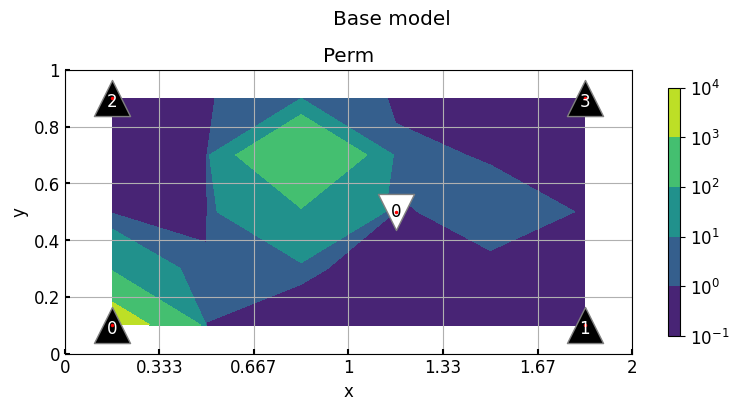

In [13]:
fig, ax = plotting.freshfig(model.name)
model.plt_field(ax, model.K[0], "perm", grid=True);

#### Simulations

In [14]:
wsat0 = np.zeros(model.Nxy)
T = 1
dt = 0.025
nTime = round(T/dt)

Let us plot the final sweep of the base model configuration.

In [15]:
def plot_final_sweep(model):
    """Simulate reservoir, plot final oil saturation."""
    wsats = model.sim(dt, nTime, wsat0, pbar=False)
    _, ax = plotting.freshfig("Final sweep -- " + model.name)
    model.plt_field(ax, wsats[-1], "oil")

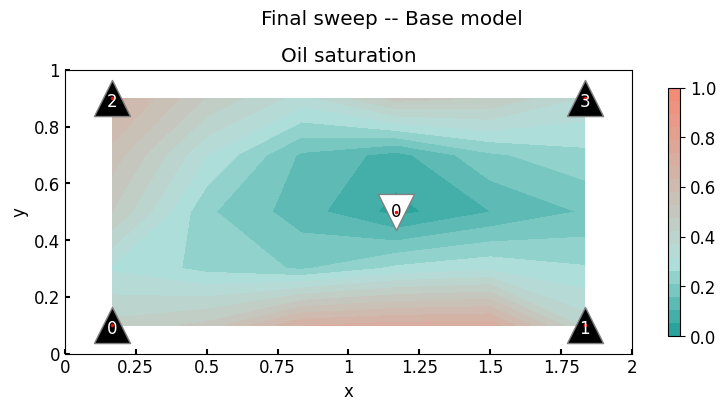

In [16]:
plot_final_sweep(model)

## NPV objective function
The NPV (objective) function,
similar to the `forward_model` of the history matching tutorial,
entails configuring and running/simulating the model.
But the main output is now the economical net value (profit),
while some other variables are included as diagnostics.
Also, importantly, note that it's all wrapped in error penalisation.

In [17]:
def npv(model, **params):
    """Discounted net present value (NPV) from model config."""
    try:
        model = remake(model, **params)
        wsats = model.sim(dt, nTime, wsat0, pbar=False)
        # Sum over wells
        prod_total = partial_volumes(model, wsats, "prod").sum(0)
        inj_total  = partial_volumes(model, wsats, "inj").sum(0)
        # Sum in time
        prod_total = prod_total @ discounts
        inj_total = inj_total @ discounts
        # Add up
        value = (price_of_oil * prod_total -
                 price_of_inj * inj_total)
        other = dict(wsats=wsats, prod_total=prod_total, inj_total=inj_total)
    except Exception:
        # Invalid model params ⇒ penalize.
        # Use `raise` for debugging.
        value, other = 0, None
    return value, other

Note that water injection has a cost.
Is seems a reasonable simplification to let this serve as a stand-in
also for the cost of GHG emissions.
We don't bother with cost of water *production*,
since it is implicitly approximated by reduction in oil production.

The following values are not motivated by any realism.
However, the 1-to-1 relationship implied by mass balance of the simulator
means that the (volumetric) price of injection must be cheapter than for oil
in order for production (even at 100% oil saturation) to be profitable.

In [18]:
price_of_inj = 50
price_of_oil = 100
discounts = .99 ** np.arange(nTime)

Note that, being defined in the global namespace,
these values cannot be manipulated by our ensemble methods.
*I.e. we cannot atm. optimise "robustly" with respect to price fluctuations.*

#### Parameter setter
Unlike the history matching tutorial, we define a parameter setter also
outside of the forward model. This will be convenient since we will do
several distinct "cases", i.e. model configurations with differences not
generated via our methods.  On the other hand, we do not bother to
implement/support permability parameterisation, as in the previous tutorial.
Note that setting parameters is not generally as trivial a task as it is here.
It might involve reshaping arrays, translating units, read/write to file, etc.
Indeed, from a "task runner" perspective, there is no hard distinction between
writing parameters and running simulations.

In [19]:
def remake(model, **params):
    """Instantiate new model config."""
    model = copy.deepcopy(model)
    for k, v in params.items():
        setattr(model, k, v)
    return model

Let's store the base model.

In [20]:
original_model = remake(model)

#### Extracting well flux from saturation fields
Also contains some minor bookkeeping
(for example, unify treatment of constant/variable rates).

In [21]:
def partial_volumes(model, wsats, inj_or_prod):
    """Essentially `saturation * rate` for `inj_or_prod` wells."""
    assert inj_or_prod in ['inj', 'prod']

    if inj_or_prod == "inj":
        rates = model.inj_rates
        saturations = 1  # 100% water
        
    elif inj_or_prod == "prod":
        rates = model.prod_rates
        well_inds = model.xy2ind(*model.prod_xy.T)
        # Use trapezoidal rule to compute saturations on *intervals*
        saturations = 0.5 * (wsats[:-1, well_inds] +
                             wsats[+1:, well_inds])
        saturations = (1 - saturations).T  # water --> oil

    # Rates constant in time ⇒ replicate for all time steps
    if rates.shape[1] == 1:
        rates = np.tile(rates, (1, nTime))
    
    # PS: Do not scale with model hx*hy
    return dt * rates * saturations

## EnOpt

#### Ensemble gradient estimator
EnOpt consists of gradient descent with ensemble gradient estimation.

In [22]:
@dataclass
class nabla_ens:
    """Ensemble gradient estimate (LLS regression)."""
    chol:    float = 1.0   # Cholesky factor (or scalar std. dev.)
    nEns:    int   = 10    # Size of control perturbation ensemble
    precond: bool  = False # Use preconditioned form?
    # Will be used later:
    robustly:None  = None  # Method of treating robust objectives
    obj_ux:  None  = None  # Conditional objective function
    X:       None  = None  # Uncertainty ensemble

    def eval(self, obj, u, pbar):
        """Estimate `∇ obj(u)`"""
        U = utils.gaussian_noise(self.nEns, len(u), self.chol)
        dU = center(U)[0]
        dJ = self.obj_increments(obj, u, u + dU, pbar)
        if self.precond:
            g = dU.T @ dJ / (self.nEns-1)
        else:
            g = utils.rinv(dU, reg=.1, tikh=True) @ dJ
        return g

    def obj_increments(self, obj, u, U, pbar):
        return apply(obj, U, pbar=pbar)  # don't need to `center`

Note the use of `apply` (which, similar to `map`, can replace a for loop)
to compute `obj(u)` for each `u` in the ensemble `U`,
which is done using multiprocessing (parallelisation).

#### Backtracking
Another ingredient to successful gradient descent is line search.

*PS: The `rtol>0` parameter specifies the minimal improvement required
to accept the updated iterate.
Larger values ⇒ more reluctance to accept update ⇒ *faster* declaration of convergence.
Setting to 0 is not recommended, because if the objective function is flat
in the neighborhood, then the path could just go in circles on that flat.*

In [23]:
@dataclass
class backtracker:
    """Bisect until improvement."""
    sign:   int   = +1                                  # Search for max(+1) or min(-1)
    xSteps: tuple = tuple(.5**(i+1) for i in range(8))  # Trial step lengths
    rtol:   float = 1e-8                                # Convergence criterion
    def eval(self, obj, u0, J0, search_direction, pbar):
        atol = max(1e-8, abs(J0)) * self.rtol
        pbar.reset(len(self.xSteps))
        for i, step_length in enumerate(self.xSteps):
            du = self.sign * step_length * search_direction
            u1 = u0 + du
            J1 = obj(u1)
            dJ = J1 - J0
            pbar.update()
            if self.sign*dJ > atol:
                pbar.reset(pbar.total)
                return u1, J1, dict(nDeclined=i)

Other acceleration techniques (AdaGrad, Nesterov, momentum,
of which git commit `9937d5b2` contains a working implementation)
could also be considered, but do not necessarily play nice with line search.

#### Gradient descent
The following implements gradient descent (GD).

In [24]:
def GD(objective, u, nabla=nabla_ens(), line_search=backtracker(), nrmlz=True, nIter=100, quiet=False):
    """Gradient (i.e. steepest) descent/ascent."""

    # Reusable progress bars (limits flickering scroll in Jupyter) w/ short np printout
    with (progbar(total=nIter, desc="⏳ GD running", leave=True,  disable=quiet) as pbar_gd,
          progbar(total=10000, desc="→ grad. comp.", leave=False, disable=quiet) as pbar_en,
          progbar(total=10000, desc="→ line_search", leave=False, disable=quiet) as pbar_ls,
          np.printoptions(precision=2, threshold=2, edgeitems=1)):

        states = [[u, objective(u), "{cause for stopping}"]]

        for itr in range(nIter):
            u, J, info = states[-1]
            pbar_gd.set_postfix(u=f"{u}", obj=f"{J:.3g}📈")

            grad = nabla.eval(objective, u, pbar_en)
            if nrmlz:
                grad /= np.sqrt(np.mean(grad**2))
            updated = line_search.eval(objective, u, J, grad, pbar_ls)
            pbar_gd.update()

            if updated:
                states.append(updated)
            else:
                cause = "✅ GD converged"
                break
        else:
            cause = "❌ GD ran out of iters"
        pbar_gd.set_description(cause)

    states[0][-1] = cause
    return [np.asarray(arr) for arr in zip(*states)]  # "transpose"

## Sanity check
It is always wise to do some dead simple testing.
Let's try a quadratic form, upended, centered on the model domain.

In [25]:
def quadratic(u):
    e = getattr(quadratic, 'ellipticity')
    u = u - [model.Lx/2, model.Ly/2]
    u = u * [1, e]
    return - np.mean(u*u, axis=-1)

Note that this objective function supports ensemble input (`u`) without the use of `apply`.
Thus -- for this case -- it would have been better had we not used `apply` in `nabla_ens`,
since multi-threaded `numpy` has less overhead than multiprocessing and is therefore faster.
Generally speaking, it may *sometimes* be better to leave parallelisation to the
model/simulator/objective function, since it is "closer to the metal"
and can therefore do more speed optimisations.
In fact, due to the overhead of multiprocessing, it is better to make `apply` use a plain for loop for this trivial case.

In [ ]:
utils.nCPU = False

Anyway, let's try out `GD` on the quadratic.

In [ ]:
@plotting.interact(seed=(1, 10), nTrial=(1, 20), ellip=(-1, 1, .1),
                   sdev=(0.01, 2), nEns=(2, 100), nIter=(0, 20))
def plot(seed=5, nTrial=2, ellip=0, sdev=.1, nEns=10, nIter=10, precond=False, nrmlz=True):
    fig, axs = plotting.figure12(quadratic.__name__)
    quadratic.ellipticity = 10**ellip

    # Compute & plot objective on mesh
    qsurf = quadratic(mesh2list(*model.mesh))
    lvls = np.linspace(qsurf.min(), qsurf.max(), 11)
    model.plt_field(axs[0], qsurf, cmap="cividis", wells=False, levels=lvls, finalize=False)

    # Run EnOpt
    for i in range(nTrial):
        rnd.seed(100*seed + i)
        u0 = rnd.rand(2) * model.domain[1]
        path, objs, info = GD(quadratic, u0, nabla_ens(sdev, nEns, precond),
                              nrmlz=nrmlz, nIter=nIter, quiet=True)
        plotting.add_path12(*axs, path, objs, color=f"C{i}", labels=False)
    fig.tight_layout()
    plotting.plt.show()

Providing you have multiple CPU's available (i.e. not on Colab),
the following will all go faster by turning on multiprocessing.

In [ ]:
utils.nCPU = True

## Case: Optimize injector location
Let's try optimising the location (x, y) of the injector well.
The objective function is simply a thin wrapper around `npv`
which translates its single (vector) input argument into `kwargs`,
and discards all output except the scalar NPV.

In [ ]:
def npv_inj_xy(xys):
    return npv(model, inj_xy=xys)[0]

In [ ]:
obj = npv_inj_xy
model = original_model

The model is sufficiently cheap that we can afford to compute the objective
over its entire 2D domain, and plot it.

In [ ]:
npvs = apply(obj, mesh2list(*model.mesh), pbar="obj(mesh)")
npvs = np.asarray(npvs)

We have in effect conducted an exhaustive computation of the objective function,
so that we already know the true, global, optimum:

In [ ]:
argmax = npvs.argmax()
print("Global (exhaustive search) optimum:", f"{npvs[argmax]:.4}",
      "at (x={:.2}, y={:.2})".format(*model.ind2xy(argmax)))

Note that the optimum is not quite in the centre of the domain,
which is caused by the asymmetry of the permeability field.

Now let's try EnOpt from a few different starting/initial guesses,
and plot the optimisation paths along with the contours of the objective
*PS: code for both tasks must be in same cell in order to plot on same figure*.

In [ ]:
# Optimize, plot paths
fig, axs = plotting.figure12(obj.__name__)
for color in ['C0', 'C2', 'C7', 'C9']:
    u0 = rnd.rand(2) * model.domain[1]
    path, objs, info = GD(obj, u0, nabla_ens(.1))
    plotting.add_path12(*axs, path, objs, color=color, labels=False)
model.plt_field(axs[0], npvs, "NPV", argmax=True, wells=False);

Note that

- The increase in objective function for each step is guaranteed by the line search
  (but could cause getting stuck in a local minimum). It is also what causes
  the step size to vanish towards later iterations.
- EnOpt uses gradient descent, which is a "local" optimizer (being gradient based).
  Therefore it can get stuck in local mimima, for example (depends on the random
  numbers used) the corner areas outside a producer.
- Even when they find the global minimum, the optimisation paths don't
  converge on the exact same point (depending on their starting point / initial guess).
  This will be further explained in the following case.

Plot of final sweep of the result of the final optimisation trial.

In [ ]:
plot_final_sweep(remake(model, inj_xy=path[-1], name=f"Optimal for {obj.__name__}"))

## Case: Optimize x-coordinate of single injector

The setters in `remake` and ResSim simplify defining the objective.
Still, sometimes we need to pre-process the arguments some more.
For example, suppose we only want to vary the x-coordinate of the injector(s),
while keeping the y-coordinate fixed.

In [ ]:
def npv_x_with_fixed_y(xs):
    xys = np.stack([xs, xs], -1) # ⇒ (1d or 2d)
    xys[..., 1] = y  # fix constant value
    return npv(model, inj_xy=xys)[0]

y = model.Ly/2

*PS: The use of `...` is a trick that allows operating on the last axis of `xys`,
which works both when it's 1d and 2d.*
Also note that we could of course have re-used `npv_inj_xy` to define `npv_x_with_fixed_y`.
This will be our approach for the subsequent case.

In [ ]:
obj = npv_x_with_fixed_y
model = original_model

x_grid = np.linspace(0, model.Lx, 201)
npvs = apply(obj, x_grid, pbar="obj(x_grid)")

In [ ]:
# Plot objective
fig, ax = plotting.freshfig(f"{obj.__name__}({y})", figsize=(7, 3))
ax.set(xlabel="x", ylabel="NPV")
ax.plot(x_grid, npvs, "slategrey", lw=3);

# Optimize, plot paths
u0s = model.Lx * np.array([[.05, .1, .2, .8, .9, .95]]).T
for i, u0 in enumerate(u0s):
    path, objs, info = GD(obj, u0, nabla_ens(.3))
    shift = .3*i  # for visual distinction
    ax.plot(path, objs - shift, '-o', c=f'C{i+1}')
fig.tight_layout()

Note that the objective functions appears to jump at regular intervals.
This would be even more apparent (no slanting of the "walls") with a higher resolution.
The phenomenon is due to the fact that the model always collocates wells with grid cell centres.
Other than this, as we might expect, the objective is nice and convex,
and EnOpt is able to find the minimum, for several different starting positions,
without much trouble.

## Case: Optimize coordinates of 2 injectors

With 2 injectors, it's more interesting (not necessary) to also only have 2 producers.
So let's configure our model for that, placing the 2 producers at the lower corners.

In [ ]:
model = remake(original_model,
    name = "Lower 2 corners",
    prod_xy = xy_4corners[:2],
    prod_rates = rate0 * np.ones((2, 1)) / 2
)

Now, as you might imagine, the optimal injector positions will be somewhere near the upper edge.
But boundaries are a problem for basic EnOpt.
Because of its Gaussian character, its gradient estimation will often sample points
outside of the domain.
This won't crash our optimisation, since the `npv` function
catches all exceptions and converts them to a penalty,
but the gradient near the border will then seem to indicate that the border is a bad place to be,
which is not necessarily the case.

- One quickfix to this issue is to truncate the ensemble members to the valid domain.
- A more sophisticated alternative is to use a non-Gaussian generalisation
  of EnOpt that samples from a Beta (e.g.) distribution,
  and uses a different formula than LLS regression to estimate the average gradient (ref. Mathias).
- The above two solutions are somewhat technically demanding,
  since they require communicating the boundaries to the gradient estimator.
  A simpler solution is to transform the control variables
  so that the domain is the whole of $\mathcal{R}^d$.

Note that these approaches can only constrain the control variables themselves,
not functions thereof (e.g. there might be rate constraints, while the control
variables are actually pressures, WBHP).

Below, we take the transformation approach.

In [ ]:
def coordinate_transform(xys):
    """Map `ℝ --> (0, L)` with `origin ↦ domain centre`, in both dims (axis 1)."""
    # An alternative to reshape/undo is slicing with 0::2 and 1::2
    xy2d = np.array(xys, dtype=float).reshape((-1, 2))
    xy2d[:, 0] = sigmoid(xy2d[:, 0], model.Lx)  # transform x
    xy2d[:, 1] = sigmoid(xy2d[:, 1], model.Ly)  # transform y
    return xy2d.reshape(np.shape(xys))

In [ ]:
def sigmoid(x, height, width=1):
    return height/(1 + np.exp(-x/width))

In [ ]:
inj_xys0 = [[-1, 0], [+1, 0]]
model = remake(model,
    inj_xy = coordinate_transform(inj_xys0),
    inj_rates = rate0 * np.ones((2, 1)) / 2,
)

The objective function is otherwise unchanged.

In [ ]:
def npv_xy_transf(xys):
    return npv_inj_xy(coordinate_transform(xys))

obj = npv_xy_transf

The objective is now a function of `2*nInj = 4` variables.
It is therefore difficult to plot (requires cross-sections or other projections)
and anyway computing it would be `nPixels_per_dim^nInj` times more costly.
We therefore just plot the (known) permeability field along with initial well layout.

In [ ]:
# Optimize
u0 = np.ravel(inj_xys0)
path, objs, info = GD(obj, u0, nabla_ens(.1))
path = coordinate_transform(path)

fig, axs = plotting.figure12(obj.__name__)
model.plt_field(axs[0], model.K[0], "perm")

# Plot optimisation trajectory
plotting.add_path12(*axs, path[:, :2], objs, color='C1')
plotting.add_path12(*axs, path[:, 2:], color='C3')
fig.tight_layout()

Seems reasonable.
A useful sanity check is provided by inspecting the resulting flow pattern.

In [ ]:
plot_final_sweep(remake(model, inj_xy=path[-1], name=f"Optimal for {obj.__name__}"))

## Case: Optimize single rate

When setting the injection rate(s), we must also
set the total production rates to be the same (this is a model constraint),
and vice-versa.

Thus, as above, we need to pre-compute something before calling `npv()`.

In [ ]:
def equalize(rates, nWell):
    """Distribute the total rate equally among `nWell`."""
    return np.tile(rates.sum(0) / nWell, (nWell, 1))

def npv_in_inj_rates(inj_rates):
    prod_rates = equalize(inj_rates, model.nProd)
    return npv(model, inj_rates=inj_rates, prod_rates=prod_rates)[0]

obj = npv_in_inj_rates
model = original_model

Again, we are able and can afford to compute and plot the entire objective.

In [ ]:
rate_grid = np.linspace(0.1, 5, 21)
npvs = apply(obj, rate_grid, pbar="obj(rate_grid)")

It makes sense that there is an optimum sweet spot somewhere in the middle.
- Little water injection ⇒ little oil production.
- Much water injection ⇒ very pricey, whereas reservoir contains finite amount of oil.

In [ ]:
# Optimize
fig, ax = plotting.freshfig(obj.__name__)
ax.grid()
ax.set(xlabel="rate", ylabel="NPV")
ax.plot(rate_grid, npvs, "slategrey")

for i, u0 in enumerate(np.array([[.1, 5]]).T):
    path, objs, info = GD(obj, u0, nabla_ens(.1))
    shift = i+1  # for visual distinction
    ax.plot(path, objs - shift, '-o', color=f'C{i+1}')
fig.tight_layout()
plotting.show()

## Case: multiple rates (with interactive/manual optimisation)
The objective is again the npv as a function of the injection rate.

In [ ]:
obj = npv_in_inj_rates

But this time let's have more injectors,
and therefore also rearrange the producers.

In [ ]:
triangle = [0, 135, -135]
wells = dict(
    inj_xy = ([[model.Lx/2, model.Ly/2]] +
              [utils.pCircle(th + 90, *model.domain[1]) for th in triangle]),
    prod_xy = [utils.pCircle(th - 90, *model.domain[1]) for th in triangle],
    inj_rates  = rate0 * np.ones((4, 1)) / 4,
    prod_rates = rate0 * np.ones((3, 1)) / 3,
)
model = remake(model, **wells, name="Triangle case")

Show well layout

In [ ]:
fig, ax = plotting.freshfig(model.name)
model.plt_field(ax, model.K[0], "perm");

Define function that takes injection rates and computes final sweep, i.e. saturation field.
Also print (with terminal color codes) the resulting NPV.

In [ ]:
@plotting.interact(
    inj0_rate = (0, 1.4),
    inj1_rate = (0, 1.4),
    inj2_rate = (0, 1.4),
    inj3_rate = (0, 1.4),
    side="right", wrap=False,
)
def interactive_rate_optim(**kwargs):
    rates = np.array([list(kwargs.values())]).T
    value, info = npv(model, inj_rates=rates, prod_rates=equalize(rates, model.nProd))
    print("NPV for these injection_rates:", f"\x1b[30;47;1m{value:.4g}\x1b[0m")
    _, ax = plotting.freshfig(obj.__name__ + " -- Interactive", wells=True)
    model.plt_field(ax, info['wsats'][-1], "oil")

#### Automatic (EnOpt) optimisation
Run EnOpt (below).

In [ ]:
u0 = .7*np.ones(model.nInj)
path, objs, info = GD(obj, u0, nabla_ens(.1))
print("Controls suggested by EnOpt:", path[-1])

Now try setting
the resulting suggested values in the interactive widget above.
Were you able to find equally good settings?

# Robust optimisation
Robust optimisation problems have a particular structure,
namely the objective is an *average*:

In [26]:
def obj(u=None, x=None):
    return np.mean([obj1(u, x) for x in uq_ens])

Of course, we still have to define the

- ensemble (`uq_ens`) providing the uncertainty quantification (UQ)
  of some parameter(s), over which the average is computed.
- conditional objective (`obj1`),
  thus labelled because it applies to 1 member in `uq_ens`.

This objective function becomes very costly to evaluate,
since it involves $2 n_{\text{Ens}}$ evaluations/simulations.
But "there are no problems -- only opportunities" or
perhaps less pompously "every problem carries the seed of its own solution".
Indeed we can exploit the structure of the robust-optimisation `obj` above
by the following patch to the way `nabla_ens` computes the increments of `obj`.

In [27]:
def dJ_robust(self, obj, u, U, pbar):
    if self.robustly == "Paired":
        dJ = apply(self.obj_ux, U, x=self.X, pbar=pbar)

    elif self.robustly == "StoSAG":
        u1 = np.tile(u, (self.nEns, 1))  # replicate u
        JU = apply(self.obj_ux, U, x=self.X, pbar=pbar)
        Ju = apply(self.obj_ux, u1, x=self.X, pbar=pbar)
        dJ = np.asarray(JU) - Ju

    elif self.robustly in ["Mean-model", "Fragile"]:
        x1 = np.tile(self.X.mean(0), (self.nEns, 1))  # replicate x
        dJ = apply(self.obj_ux, U, x=x1, pbar=pbar)

    else:  # Regular/"naive" (M*N costly) form
        dJ = apply(obj, U, pbar=pbar)

    return dJ

In [28]:
nabla_ens.obj_increments = dJ_robust

Note that the computational cost of is $2 n_{\text{Ens}}$ simulations
rather than $n_{\text{Ens}}^2$ (assuming ensembles of equal size, $n_{\text{Ens}}$).
For small $n_{\text{Ens}}$ this cost saving is not palpable,
especially since backtracking will also perform a few iterations of $n_{\text{Ens}}$ evaluations.
But if $n_{\text{Ens}} > 30$ the cost savings become salient.

PS: The cost of `nabla_ens.obj_increments` could be further reduced to just $n_{\text{Ens}}$ simulations
by not computing `Ju`, instead obtaining these objective values
from the latest `backtracker` evaluations.
However, for the sake of code simplicity,
we do not implement the necessary intercommunication,
preferring to keep `GD` and `backtracker` entirely generic,
i.e. unaware of any conditional objectives.

## Case: Optimize injector location (x, y) under uncertain permeability

### Uncertainty quantification

In [29]:
nEns = 31
rnd.seed(5)
uq_ens = .1 + np.exp(5 * geostat.gaussian_fields(model.mesh, nEns, r=0.8))

Plot

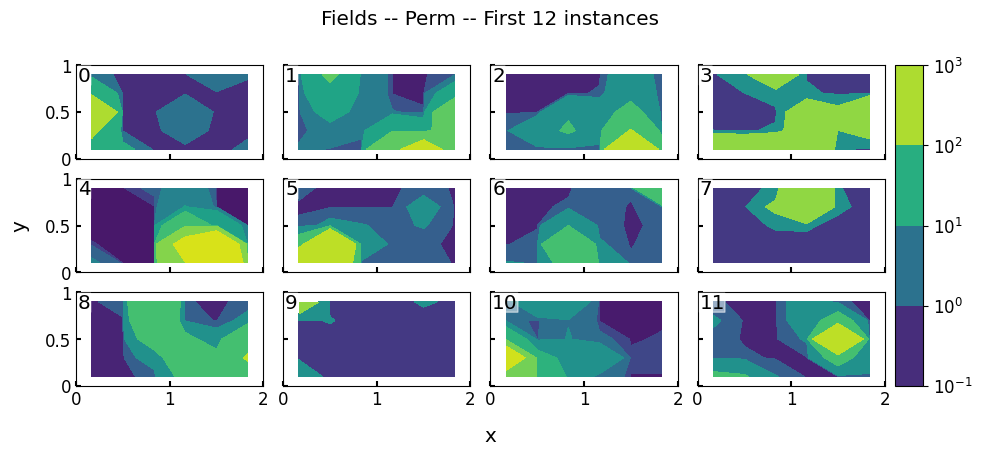

In [32]:
plotting.fields(model, uq_ens, "perm");

### Conditional objective
The *conditional* objective consists of the `npv`
at some `inj_xy=u` for a  given permability `K=x`.

In [34]:
def obj1(u, x):
    return npv(model, inj_xy=u, K=x)[0]

model = original_model

Case: 'obj1' for 'Base model'


### Ensemble of objectives

NB: since it involves $n_{\text{Ens}}$ model simulations for each grid cell,
computing the ensemble of conditional objective surfaces can take quite long.
So you should skip these computations if you're on a slow computer.

In [35]:
try:
    import google.colab  # type: ignore
    my_computer_is_fast = False # Colab is slow
except ImportError:
    my_computer_is_fast = True

obj1(u=mesh, x=ens)


map(<lambda>, ...):   0%||          | 0/31, ⏱️ 00:00, ?it/s

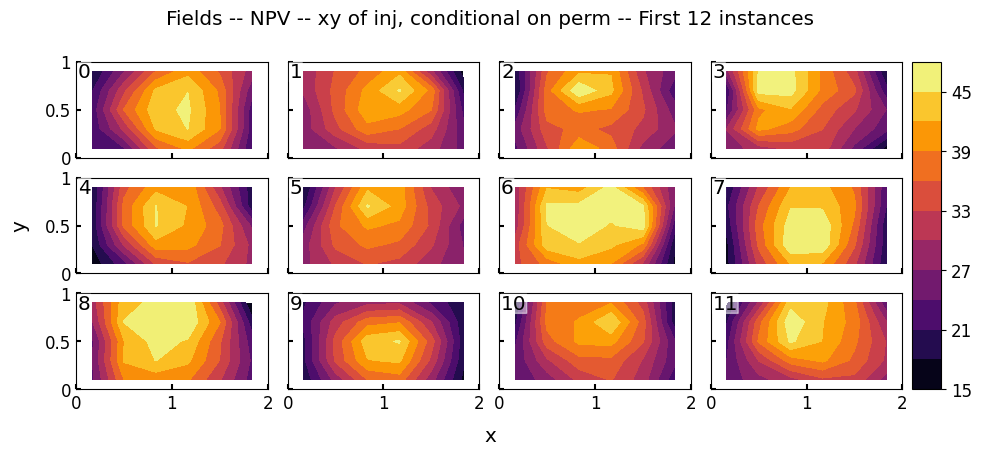

Global (exhaustive search) optimum: obj=42.53 (x=0.83, y=0.5)


In [36]:
if my_computer_is_fast:
    npv_mesh = apply(lambda x: [obj1(u, x) for u in mesh2list(*model.mesh)], uq_ens)
    plotting.fields(model, npv_mesh, "NPV", "xy of inj, conditional on perm");

    # Thus we know the global optimum of the total/robust objective.
    npv_avrg = np.mean(npv_mesh, 0)
    argmax = npv_avrg.argmax()
    print("Global (exhaustive search) optimum:",
          f"obj={npv_avrg[argmax]:.4}",
          "(x={:.2}, y={:.2})".format(*model.ind2xy(argmax)))

### Optimize, plot paths

⏳ GD running:   0%||          | 0/100, ⏱️ 00:00, ?it/s

→ grad. comp.:   0%||          | 0/10000, ⏱️ 00:00, ?it/s

→ line_search:   0%||          | 0/10000, ⏱️ 00:00, ?it/s

⏳ GD running:   0%||          | 0/100, ⏱️ 00:00, ?it/s

→ grad. comp.:   0%||          | 0/10000, ⏱️ 00:00, ?it/s

→ line_search:   0%||          | 0/10000, ⏱️ 00:00, ?it/s

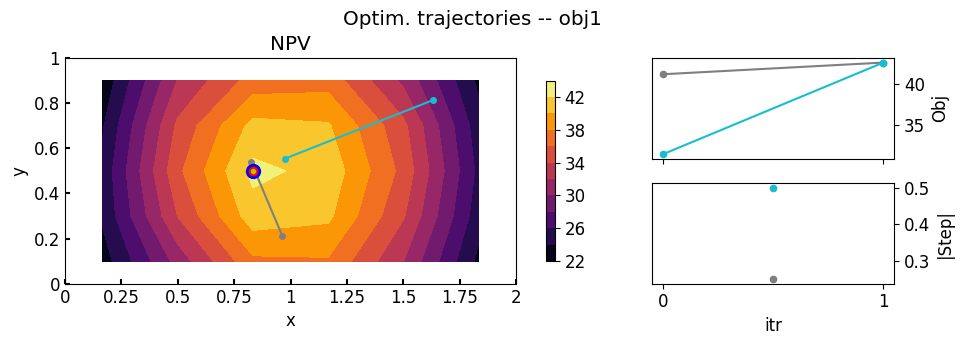

In [38]:
fig, axs = plotting.figure12(obj1.__name__)
if my_computer_is_fast:
    model.plt_field(axs[0], npv_avrg, "NPV", argmax=True, wells=False, finalize=False)

    # Use "naive" ensemble gradient
    for color in ['C0', 'C2']:
        u0 = rnd.rand(2) * model.domain[1]
        path, objs, info = GD(obj, u0, nabla_ens(.1, nEns=nEns))
        plotting.add_path12(*axs, path, objs, color=color, labels=False)

# Use StoSAG ensemble gradient
for color in ['C7', 'C9']:
    u0 = rnd.rand(2) * model.domain[1]
    path, objs, info = GD(obj, u0, nabla_ens(.1, nEns=nEns, obj_ux=obj1, X=uq_ens, robustly="StoSAG"))
    plotting.add_path12(*axs, path, objs, color=color, labels=False)

fig.tight_layout();

Clearly, optimising the full objective with "naive" EnOpt is very costly,
but is significantly faster using robust EnOpt (StoSAG), in particular if $n_{\text{Ens}} > 30$.

You may also want to experiment with the other alternatives for `robustly`, i.e. "Mean-model" and "Paired".

Let us store the optimum of the last trial of StoSAG.

In [ ]:
ctrl_robust = path[-1]

### Nominally (conditionally/individually) optimal controls

It is also (academically) interesting to consider the optimum for the conditional objective,
i.e. for a single uncertain parameter member/realisation vector in `uq_ens`.
We can thus generate an ensemble of such nominally optimal control strategies.

In [ ]:
ctrl_ens_nominal = []
for x in progbar(uq_ens, desc="Nominal optim."):
    u0 = rnd.rand(2) * model.domain[1]
    path, objs, info = GD(lambda u: obj1(u, x), u0, nabla_ens(.1, nEns=nEns), quiet=True)
    ctrl_ens_nominal.append(path[-1])

Alternatively, since we have already computed the npv for each pixel/cell
for each uncertain ensemble member, we can get the globally nominally optima.

In [ ]:
if my_computer_is_fast:
    ctrl_ens_nominal2 = model.ind2xy(np.asarray(npv_mesh).argmax(axis=1)).T

The following matplotlib code produces a scatter plot of the nominal optima (`ctrl_ens_nominal`)
for the injector well. The scatter locations are labelled with the corresponding uncertainty realisation.

In [ ]:
cmap = plotting.plt.get_cmap('tab20')
fig, ax = plotting.freshfig("Optima")
lbl_props = dict(fontsize="large", fontweight="bold")
lbls = []
for n, (x, y) in enumerate(ctrl_ens_nominal):
    color = cmap(n % 20)
    ax.scatter(x, y, s=6**2, color=color, lw=.5, edgecolor="w")
    lbls.append(ax.text(x, y, n, c=color, **lbl_props))
    if my_computer_is_fast:
        x2, y2 = ctrl_ens_nominal2[n]
        ax.plot([x, x2], [y, y2], '-', color=color, lw=1)
ax.scatter(*ctrl_robust, s=8**2, color="w")
utils.adjust_text(lbls, precision=.1);
model.plt_field(ax, np.zeros_like(model.mesh[0]), "domain",
                wells=False, colorbar=False, grid=True)

Also drawn are lines to/from the true/global nominal optima (if `my_computer_is_fast`).
It can be seen that EnOpt mostly, but not always, finds the global optimum
for this case.

### Histogram (KDE) for each control strategy

Let us assess (evaluate) the performance of the robust optimal control vector
for each of the parameter possibilities (i.e. each realisation in `uq_ens`).
*PS: this was of course already computed as part of the iterative optimisation
procedure, but was not included it among its outputs.*

In [ ]:
npvs_robust = apply(lambda x: obj1(ctrl_robust, x), uq_ens)

We can do the same for each nominally optimal control vector.
*PS: we could also do the same for `ctrl_ens_nominal2`.*

In [ ]:
npvs_condnl = apply(lambda u: [obj1(u, x) for x in uq_ens], ctrl_ens_nominal)

Note that `npvs_condnl` is of shape `(nEns, nEns)`,
the first index (i.e. each row) corresponds to a nominally optimal control parameter vector.
We can construct a histogram for each one,
but it's difficult to visualize several histograms together.
Instead, following [Essen2009](#Essen2009), we use (Gaussian) kernel density estimation (KDE)
to create a "continuous" histogram, i.e. an approximate probability density.
The following code is a bit lengthy due to plotting details.

In [ ]:
from scipy.stats import gaussian_kde

fig, ax = plotting.freshfig("NPV densities for optimal controls", figsize=(7, 4))
ax.set_xlabel("NPV")
ax.set_ylabel("Density (pdf)");

a, b = np.min(npvs_condnl), np.max(npvs_condnl)
npv_grid = np.linspace(a, b, 100)

lbls = []
for n, npvs_n in enumerate(npvs_condnl):
    color = cmap(n % 20)
    kde = gaussian_kde(npvs_n)
    ax.plot(npv_grid, kde(npv_grid), c=color, lw=1.2, alpha=.7)

    # Label curves
    x = a + n*(b-a)/nEns
    lbls.append(ax.text(x, kde(x).item(), n, c=color, **lbl_props))
    ax.scatter(x, kde(x), s=2, c=color)

# Add robust strategy
ax.plot(npv_grid, gaussian_kde(npvs_robust).evaluate(npv_grid), "w", lw=3)

# Legend showing mean values
leg = (f"         Mean    Min",
       f"Robust:  {np.mean(npvs_robust):<6.3g}  {np.min(npvs_robust):.3g}",
       f"Nominal: {np.mean(npvs_condnl):<6.3g}  {np.min(npvs_condnl):.3g}")
ax.text(.02, .97, "\n".join(leg), transform=ax.transAxes, va="top", ha="left",
        fontsize="medium", fontfamily="monospace", bbox=dict(
            facecolor='lightyellow', edgecolor='k', alpha=0.99,
            boxstyle="round,pad=0.25"))

ax.tick_params(axis="y", left=False, labelleft=False)
ax.set(facecolor="k", ylim=0, xlim=(a, b))
utils.adjust_text(lbls)
fig.tight_layout()
plotting.show()

# Multi-objective optimisation
Compared to [Angga2022](#Angga2022) 5-spot case:

- No compressibility
- Different model rectangle
- Simplified geology (permeability)
- Injection is constant in time and across wells

Only the 1st item would be hard to change.

In [ ]:
model = remake(original_model,
    name = "Angga2022-5spot",
    prod_xy = [[model.Lx/2, model.Ly/2]],
    inj_xy = xy_4corners,
    prod_rates  = rate0 * np.ones((1, 1)) / 1,
    inj_rates = rate0 * np.ones((4, 1)) / 4,
)

plot_final_sweep(model)

In [ ]:
def npv_in_prod_rates(prod_rates):
    inj_rates = equalize(prod_rates, model.nInj)
    return npv(model, prod_rates=prod_rates, inj_rates=inj_rates)[0]

obj = npv_in_prod_rates

#### Optimize

In [ ]:
fig, ax = plotting.freshfig(obj.__name__)
rate_grid = np.logspace(-2, 1, 31)
optimal_rates = []
# cost_multiplier = [.01, .04, .1, .4, .9, .99]
__default__ = price_of_inj
cost_multiplier = np.arange(0.1, 1, 0.1)
for i, xCost in enumerate(cost_multiplier):
    price_of_inj = __default__ * xCost
    npvs = apply(obj, rate_grid, pbar="obj(rate_grid)")
    ax.plot(rate_grid, npvs, label=f"{xCost:.1}")
    path, objs, info = GD(obj, np.array([2]), nabla_ens(.1))
    optimal_rates.append(path[-1])
price_of_inj = __default__  # restore
ax.set_ylim(1e-2)
ax.legend(title="×price_of_inj")
ax.set(xlabel="rate", ylabel="NPV")
ax.grid()
fig.tight_layout()
plotting.show()

#### Pareto front
Breakdown npv (into emissions and sales) for optima

In [ ]:
sales = []
emissions = []
for i, prod_rates in enumerate(optimal_rates):
    inj_rates = equalize(prod_rates, model.nInj)
    value, other = npv(model, prod_rates=prod_rates, inj_rates=inj_rates)
    sales.append(other['prod_total'])
    emissions.append(other['inj_total'])

In [ ]:
fig, ax = plotting.freshfig("Pareto front (npv-optimal settings for range of price_of_inj)")
ax.set(xlabel="npv (income only)", ylabel="inj/emissions (expenses)")
ax.plot(sales, emissions, "o-")
ax.grid()
fig.tight_layout()

## References

<a id="Essen2009">[Essen2009]</a>: van Essen, G., M. Zandvliet, P. Van den Hof, O. Bosgra, and J.-D. Jansen. *Robust waterflooding optimization of multiple geological scenarios.* **SPE Journal**, 14(01):202–210, 2009.

<a id="Angga2022">[Angga2022]</a>: Angga, I. G. A. G., M. Bellout, B. S. Kristoffersen, P. E. S. Bergmo, P. A. Slotte, and C. F. Berg. *Effect of CO2 tax on energy use in oil production: waterflooding optimization under different emission costs.* **SN Applied Sciences**, 4(11):313, 2022

<a id="">[Fonseca2017]</a>: Fonseca, R. M., B. Chen, J. D. Jansen, and A. Reynolds. *A stochastic simplex approximate gradient (StoSAG) for optimization under uncertainty.* **International Journal for Numerical Methods in Engineering**, 109(13):1756– 1776, 2017. doi: 10.1002/nme.5342.

<a id="">[Raanes2023]</a>: Raanes, P. N., A. S. Stordal, and R. J. Lorentzen. *Review of ensemble gradients for robust optimisation*, 2023. doi: 10.48550/arXiv.2304.12136

<a id="">[Chen2009]</a>: Chen, Y., D. S. Oliver, and D. Zhang. *Efficient ensemble-based closed- loop production optimization.* **SPE Journal**, 14(04):634–645, 2009. doi: 10.2118/112873-PA.